# Vector Bayes Learnable Generative Masks

In this code we will:
1. Generate a lot of masks and their property vectors
2. Given a property list, fetch its mask
3. Bayesian Optimize over the property to maximize model performance

# NN to graph

In [ ]:
import numpy as np
import networkx as nx
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import gridspec


import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm


from torchvision import datasets
from torchvision.transforms import ToTensor


import torch.nn.utils.prune as prune

In [ ]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=9762241c2aa28344cce8589c55653b0dc028f9d4ba85e0f9a05a05e6da39e1d2
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


# Training and masking utils

In [ ]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(),
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transforms.ToTensor(),
    download = True
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

X_train = train_data.data.reshape(-1, 28*28).float().to(device)
y_train = train_data.targets.to(device)
X_test = test_data.data.reshape(-1, 28*28).float().to(device)
y_test = test_data.targets.to(device)


class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        # self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        # self.linear4 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim)     

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        # x = F.relu(self.linear3(x))
        # x = F.relu(self.linear4(x))
        x = F.softmax(self.linear3(x), dim=1)
        return x

def train(model, epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  criterion = nn.CrossEntropyLoss()
  loss_list  = np.zeros((epochs,))
  accuracy_list = np.zeros((epochs,))

#   for epoch in tqdm.trange(epochs):
  for epoch in range(epochs):
      y_pred = model(X_train)
      loss = criterion(y_pred, y_train)
      loss_list[epoch] = loss.item()
      
      # Zero gradients
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      with torch.no_grad():
          y_pred = model(X_test)
          correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
          accuracy_list[epoch] = correct.mean()

  return model, accuracy_list, loss_list


def plot(accuracy_list, loss_list):
  fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

  ax1.plot(accuracy_list)
  ax1.set_ylabel("validation accuracy")
  ax2.plot(loss_list)

  ax2.set_ylabel("validation loss")
  ax2.set_xlabel("epochs");     


def _model_performance(model, N_ITERS=50):
  model, _, _ = train(model, N_ITERS)
  with torch.no_grad():
    y_pred = model(X_test)
    correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
    accuracy = correct.mean()
  return accuracy      

def model_performance(mask, N_ITERS=50):
  model = LogisticRegressionModel(INP_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
  mask = mask.to(device)
  prune.custom_from_mask(model.linear2, name='weight', mask=mask.to(device))
  return _model_performance(model, N_ITERS)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

cuda:0


In [ ]:
def random_mask(hd, sparsity):
  mask = np.random.uniform(size=(hd, hd))
  mask = np.triu(mask, k=0)
  mask = (mask > sparsity).astype(int)
  mask = np.maximum(mask, mask.T)
  mask = torch.from_numpy(mask)
  return mask

def fixed_width_mlp_layer(mask):
  mask = mask.numpy()
  return nx.from_numpy_array(mask)

def compute_c(G):
    G_cluster = list(nx.clustering(G).values())
    return sum(G_cluster) / len(G_cluster)  

In [ ]:
properties = {
    "avg_degree_centrality": lambda x: np.array(list(nx.degree_centrality(x).values())).mean(),
    "average_degree_connectivity": lambda x: np.array(list(nx.average_degree_connectivity(x).values())).mean(),
    "eigenvector_centrality": lambda x: np.array(list(nx.eigenvector_centrality(x).values())).mean(),
    "clustering_coefficient": lambda x: nx.average_clustering(x),
    "average_shortest_path_length": lambda x: nx.average_shortest_path_length(x),
    "s_metric": lambda x: nx.s_metric(x, False),
    "wiener_index": lambda x: nx.wiener_index(x),
    "edge_connectivity": lambda x: nx.edge_connectivity(x),
    "n_cycles": lambda x: len(nx.find_cycle(G))
}

def compute_properties(G):
  return [p(G) for p in list(properties.values())]

In [ ]:
mask = random_mask(100, 0.5)
G = fixed_width_mlp_layer(mask)
compute_properties(G)

[0.5022222222222222,
 49.600863918079206,
 0.0995506392450513,
 0.4910355664797759,
 1.5074747474747474,
 6256757.0,
 7462.0,
 39,
 1]

# Generate Masks

In [ ]:
HIDDEN_DIM = 128
SPARSITY = 0.6
N_MASKS = 100
mask_db = []
for i in tqdm.notebook.tqdm(range(N_MASKS)):
  mask = random_mask(HIDDEN_DIM, SPARSITY)
  G = fixed_width_mlp_layer(mask)  
  ps = compute_properties(G)
  mask_db.append([mask, ps])

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(np.array([item[1] for item in mask_db]))
df.columns = list(properties.keys())

In [ ]:
df

,avg_degree_centrality,average_degree_connectivity,eigenvector_centrality,clustering_coefficient,average_shortest_path_length,s_metric,wiener_index,edge_connectivity,n_cycles
0,0.408588,51.910990,0.087896,0.402393,1.598548,9131771.0,12993.0,39.0,3.0
1,0.407357,52.040178,0.087850,0.400294,1.599163,9085670.0,12998.0,40.0,1.0
2,0.407972,52.087573,0.087855,0.403077,1.598302,9122613.0,12991.0,33.0,3.0
3,0.407480,52.128302,0.087814,0.403933,1.598425,9102476.0,12992.0,36.0,1.0
4,0.406004,51.661028,0.087991,0.399680,1.599779,8935651.0,13003.0,41.0,1.0
...,...,...,...,...,...,...,...,...,...
95,0.411663,52.385770,0.087924,0.402610,1.594857,9338513.0,12963.0,39.0,1.0
96,0.400344,50.922470,0.087978,0.395422,1.606176,8568580.0,13055.0,37.0,1.0
97,0.405758,51.580785,0.087877,0.400983,1.600148,8959353.0,13006.0,36.0,1.0
98,0.406988,52.015856,0.087788,0.401920,1.598548,9075963.0,12993.0,36.0,1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


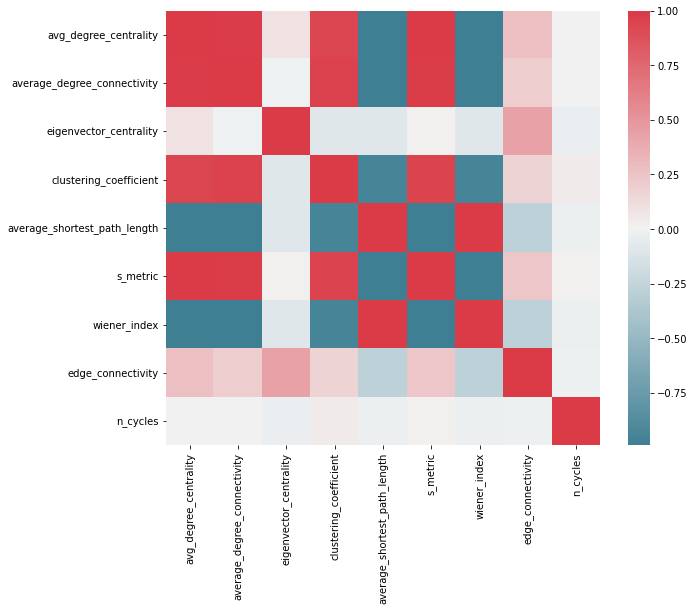

In [ ]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,avg_degree_centrality,average_degree_connectivity,eigenvector_centrality,clustering_coefficient,average_shortest_path_length,s_metric,wiener_index,edge_connectivity,n_cycles
avg_degree_centrality,1.00,0.98,0.09,0.94,-0.99,1.00,-0.99,0.27,0.01
average_degree_connectivity,0.98,1.00,-0.01,0.95,-0.98,0.99,-0.98,0.20,0.01
eigenvector_centrality,0.09,-0.01,1.00,-0.09,-0.10,0.02,-0.10,0.44,-0.03
clustering_coefficient,0.94,0.95,-0.09,1.00,-0.95,0.95,-0.95,0.17,0.05
average_shortest_path_length,-0.99,-0.98,-0.10,-0.95,1.00,-0.99,1.00,-0.28,-0.02
s_metric,1.00,0.99,0.02,0.95,-0.99,1.00,-0.99,0.24,0.01
wiener_index,-0.99,-0.98,-0.10,-0.95,1.00,-0.99,1.00,-0.28,-0.02
edge_connectivity,0.27,0.20,0.44,0.17,-0.28,0.24,-0.28,1.00,-0.01
n_cycles,0.01,0.01,-0.03,0.05,-0.02,0.01,-0.02,-0.01,1.00


In [ ]:
drops = [
         "average_degree_connectivity",
         "s_metric",
         "average_shortest_path_length",
         "wiener_index",
]

properties = {k:properties[k] for k in properties if k not in drops}

def compute_properties(G):
  return [p(G) for p in list(properties.values())]

In [ ]:
properties
#eigenvectors -- graph properties
#cycle based propertiessli

{'avg_degree_centrality': <function __main__.<lambda>>,
 'clustering_coefficient': <function __main__.<lambda>>,
 'edge_connectivity': <function __main__.<lambda>>,
 'eigenvector_centrality': <function __main__.<lambda>>,
 'n_cycles': <function __main__.<lambda>>}

# BayesOpt For Learning Masks with Certain Properties

## Start with fixed sparsity
### Generate masks again

In [ ]:
INP_DIM = X_train.shape[1]
HIDDEN_DIM = 128
SPARSITY = 0.6
OUTPUT_DIM = 10
N_MASKS = 1000
N_ITER_TRAIN = 50

### Generate Mask DB

In [ ]:
mask_db = []
for i in tqdm.notebook.tqdm(range(N_MASKS)):
  mask = random_mask(HIDDEN_DIM, SPARSITY)
  G = fixed_width_mlp_layer(mask)  
  ps = compute_properties(G)
  mask_db.append([mask, ps])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# mask_db

In [ ]:
assert len(mask_db[0][1])==len(properties)

mask_vecs = np.array([item[1] for item in mask_db])
mins = mask_vecs.min(0)
maxs = mask_vecs.max(0)
ranges = {
    list(properties.keys())[i]:(mins[i], maxs[i]) for i in range(len(properties))
}
for p in ranges:
  print(f"{p}: {ranges[p][0]}-{ranges[p][1]}")

M = mask_vecs.ptp(0)
D = mask_vecs.min(0)
mask_vecs = (mask_vecs - D) / M
mask_vecs = sklearn.preprocessing.normalize(mask_vecs, norm="l2")

avg_degree_centrality: 0.38508858267716545-0.42470472440944884
eigenvector_centrality: 0.08765953197717677-0.08805724290498909
clustering_coefficient: 0.3765750930033349-0.4173340685957204
edge_connectivity: 27.0-43.0
n_cycles: 1.0-7.0


In [ ]:
# mask_db

In [ ]:
def preprocess(v):
  v = (v-D)/M
  return sklearn.preprocessing.normalize(v.reshape(-1,1), axis=0, norm="l2").ravel()

def fetch_mask(p):
  p = preprocess(p)
  idx = mask_vecs.dot(new).argmax()
  return mask_db[idx][0]  

p = mask_db[65][1]
new = preprocess(p)
print(mask_vecs.dot(new).argmax())
fetch_mask(p)

65


tensor([[1, 1, 0,  ..., 0, 1, 0],
        [1, 0, 0,  ..., 0, 0, 1],
        [0, 0, 1,  ..., 1, 1, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0]])

In [ ]:
def f(**kwargs):
  p = np.array(list(kwargs.values()))
  mask = fetch_mask(p)
  return model_performance(mask, N_ITER_TRAIN)

In [ ]:
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(
    f, 
    ranges,
    random_state=42
)

In [ ]:
optimizer.maximize(init_points=5, n_iter=20, kappa=5)

|   iter    |  target   | avg_de... | cluste... | edge_c... | eigenv... | n_cycles  |
-------------------------------------------------------------------------------------
|  1        |  0.7145   |  0.3999   |  0.4153   |  38.71    |  0.0879   |  1.936    |
|  2        |  0.9056   |  0.3913   |  0.3789   |  40.86    |  0.0879   |  5.248    |
|  3        |  0.7395   |  0.3859   |  0.4161   |  40.32    |  0.08774  |  2.091    |
|  4        |  0.665    |  0.3924   |  0.389    |  35.4     |  0.08783  |  2.747    |
|  5        |  0.5507   |  0.4093   |  0.3823   |  31.67    |  0.08781  |  3.736    |
|  6        |  0.7493   |  0.4247   |  0.4173   |  43.0     |  0.08801  |  7.0      |
|  7        |  0.7471   |  0.4247   |  0.3766   |  38.27    |  0.08766  |  7.0      |
|  8        |  0.7482   |  0.3851   |  0.3766   |  43.0     |  0.08766  |  3.712    |
|  9        |  0.5856   |  0.3887   |  0.4124   |  27.01    |  0.08777  |  6.876    |
|  10       |  0.8374   |  0.4247   |  0.4173   |  27.

In [ ]:
optimizer.maximize(init_points=24, n_iter=1, kappa=5)

|   iter    |  target   | avg_de... | cluste... | edge_c... | eigenv... | n_cycles  |
-------------------------------------------------------------------------------------
|  1        |  0.6858   |  0.3999   |  0.4153   |  38.71    |  0.0879   |  1.936    |
|  2        |  0.8345   |  0.3913   |  0.3789   |  40.86    |  0.0879   |  5.248    |
|  3        |  0.7391   |  0.3859   |  0.4161   |  40.32    |  0.08774  |  2.091    |
|  4        |  0.6356   |  0.3924   |  0.389    |  35.4     |  0.08783  |  2.747    |
|  5        |  0.835    |  0.4093   |  0.3823   |  31.67    |  0.08781  |  3.736    |
|  6        |  0.656    |  0.4162   |  0.3847   |  35.23    |  0.0879   |  1.279    |
|  7        |  0.7411   |  0.4092   |  0.3835   |  28.04    |  0.08804  |  6.794    |
|  8        |  0.837    |  0.4171   |  0.389    |  28.56    |  0.08793  |  3.641    |
|  9        |  0.7593   |  0.3899   |  0.3968   |  27.55    |  0.08802  |  2.553    |
|  10       |  0.6832   |  0.4113   |  0.3893   |  35.

In [ ]:
# Todo

# Todo:
- Compare with other pruning methods
- Compare with no pruning model

In [ ]:
winner_ticket = optimizer.max
winner_mask = fetch_mask(list(winner_ticket['params'].values()))
winner_ticket

{'params': {'avg_degree_centrality': 0.4064095655875948,
  'clustering_coefficient': 0.4177625270029351,
  'edge_connectivity': 42.74978680128863,
  'eigenvector_centrality': 0.08784128644723256,
  'n_cycles': 3.208665738660938},
 'target': 0.9257000088691711}

In [ ]:
winner_mask

tensor([[1, 0, 0,  ..., 0, 0, 1],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 1, 1],
        [0, 0, 1,  ..., 1, 1, 0],
        [1, 0, 1,  ..., 1, 0, 0]])

# Baselines

In [ ]:
!git clone https://github.com/jaeho-lee/layer-adaptive-sparsity
!mv layer-adaptive-sparsity/* .
!rm layer-adaptive-sparsity -r
!ls

import torch,argparse,random,os
import numpy as np
from tools import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

Cloning into 'layer-adaptive-sparsity'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 34 (delta 2), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (34/34), done.
data  iterate.py  README.md  sample_data  tools


In [ ]:
PRUNING_METHODS = "lamp glob unif unifplus erk".split()        
amount_per_it = SPARSITY/3
P = PRUNING_METHODS[2]
print(f"Pruning method: {P} | Amount: {amount_per_it}")
pruner = weight_pruner_loader(P)

Pruning method: unif | Amount: 0.19999999999999998


In [ ]:
model = LogisticRegressionModel(INP_DIM, HIDDEN_DIM, OUTPUT_DIM)
print(get_model_sparsity(model))

1.0


In [ ]:
pruner(model, amount_per_it)
print(get_model_sparsity(model))

0.8000016946854663


In [ ]:
_model_performance(model.to(device))

tensor(0.7604)

# Plot the process

In [ ]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["c"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((1, 0))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((0, 1))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [ ]:
X = np.linspace(0, 1, 20).reshape(-1, 1)
Y = [f(x) for x in tqdm.notebook.tqdm(X)]

  0%|          | 0/20 [00:00<?, ?it/s]

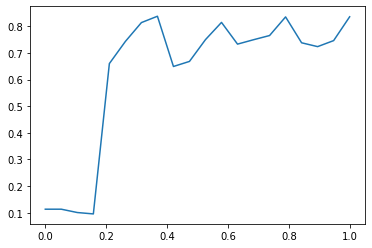

In [ ]:
plt.plot(X, Y)

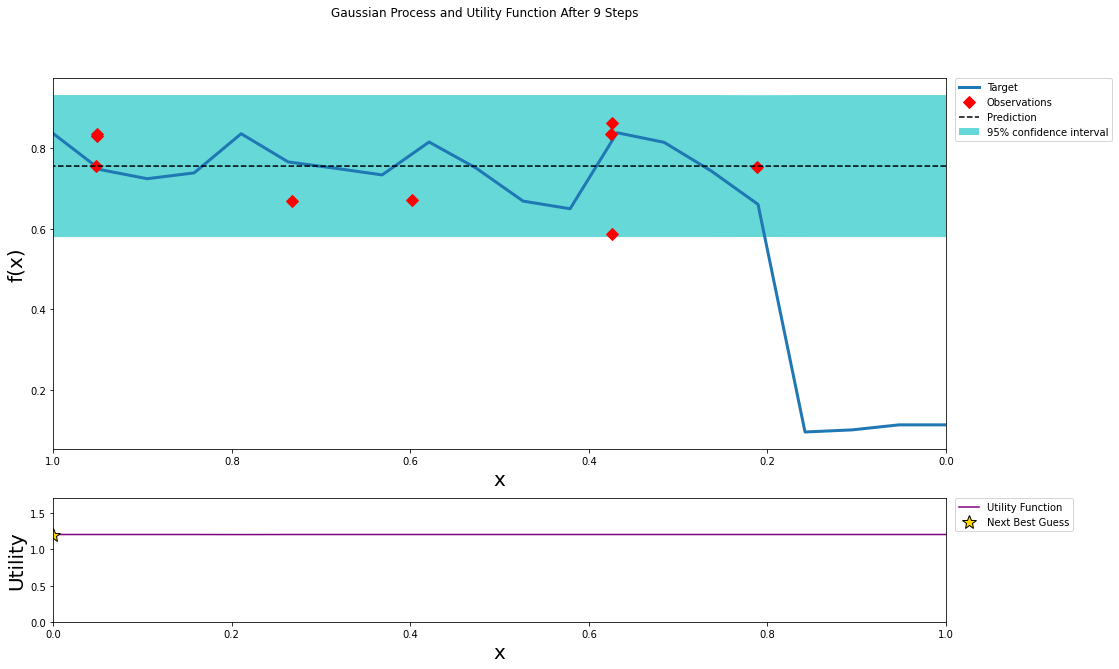

In [ ]:
from bayes_opt import UtilityFunction
plot_gp(optimizer, X, Y)